# Evolutionary Algorithm to Optimise Traveling Salesman Problem

In [22]:
import xmltodict
import random
import numpy as np
import matplotlib.pyplot as plt

## Assigning File Name and Number of Edges
### Change the file name and corresponding number of edges according to the country

In [23]:
file_name = "brazil58.xml"
num_of_edges = 58

## Parsing XML file and Calculating Distance Matrix

In [24]:
xml_file = open(file_name, "r").read()
data = xmltodict.parse(xml_file)

edges = data["travellingSalesmanProblemInstance"]["graph"]["vertex"]
list = []
source = 0

for edge in edges:
    for i in edge["edge"]:
        item = [float(i["@cost"])]
        list.append(item)
    source = source + 1

matrix = []
temp_list = []
counter = 0

# Running throup the matrix to insert 0's at the diagnals 
for i in range(0, num_of_edges):
    for j in range(0, num_of_edges):
        if i == j:
            temp_list.append(0)
        else:
            temp_list.append(list[counter][0])
            counter = counter + 1
    matrix.append(temp_list)
    temp_list = []

## Defining Population Size and Tournament Size for the Experiment

In [25]:
population_size = 100
tournament_size = 20
termination_criteria = 10000

## Initialise Population

In [26]:
# Function to initialise population 
def initPopulation(population_size):
    population = []
    cities = [i for i in range(len(matrix))]
    while len(population) < population_size:
        path = cities.copy()   
        random.shuffle(path) # Shuffling to randomise paths
        if path not in population:
            population.append(path)
    return population

## Funcion to Calculate Fitness

In [27]:
# Function to calculate total cost/fitness of a particular path
def calculateTotalFitness(path, distance_matrix):
    total_cost = 0
    num_vertices = len(distance_matrix)

    for i in range(len(path)):
        source_vertex = path[i]
        dest_vertex = path[(i + 1) % num_vertices]  
        cost_segment = distance_matrix[source_vertex][dest_vertex] # Seacrching for the cost in the distance matrix using the coordinates
        total_cost += cost_segment

    return total_cost

## Define Tournament and Select Two Parents

In [28]:
print("Tournament Size: " + str(tournament_size))

# Function to perform Tournament Selection
def tournamentSelection(population, tournament_size):
    best_path = None
    best_score = float('inf')  # Initialize with positive infinity to find the minimum score
    for _ in range(tournament_size):
        random_index = random.randint(0, len(population) - 1)
        candidate_path = population[random_index]
        candidate_score = calculateTotalFitness(candidate_path, matrix)
        if candidate_score < best_score: # Condition to check for path with lowest fitness
            best_path = candidate_path
            best_score = candidate_score
    return best_path, best_score

Tournament Size: 20


## Implementation of All Parameters and Operators

### Function to Perform Crossover

In [29]:
def performCrossover(crossover_type, parent_1, parent_2): 
    # Code to perform One-Point Crossover
    if crossover_type == 'ONE_POINT_CROSSOVER': 
        crossover_point = random.randint(1, len(parent_1) - 1) # Uses one point to perform the crossover
        child_1 = parent_1[:crossover_point] + [city for city in parent_2 if city not in parent_1[:crossover_point]]
        child_2 = parent_2[:crossover_point] + [city for city in parent_1 if city not in parent_2[:crossover_point]]

        return child_1, child_2

    # Code to perform Two-Point Crossover
    elif crossover_type == 'TWO_POINT_CROSSOVER':
        n = len(parent_1)
        crossover_points = sorted(random.sample(range(1, n), 2))
        point1, point2 = crossover_points # Uses two points to perform the crossover

        child_1 = [-1] * n
        child_2 = [-1] * n

        child_1[point1:point2] = parent_1[point1:point2]
        child_2[point1:point2] = parent_2[point1:point2]

        idx_1, idx_2 = 0, 0

        for i in range(n):
            if point1 <= i < point2:
                continue

            while parent_2[idx_1] in child_1:
                idx_1 = (idx_1 + 1) % n
            child_1[i] = parent_2[idx_1]

            while parent_1[idx_2] in child_2:
                idx_2 = (idx_2 + 1) % n
            child_2[i] = parent_1[idx_2]

        return child_1, child_2
    
    else:
        print("Error at Crossover!")

### Function to Perform Mutation

In [30]:
def performMutation(mutation_type, path):
    # Code to perform Single-Swap Mutation
    if mutation_type == 'SINGLE_SWAP_MUTATION':
        mutated_path = path[:]
        position_1, position_2 = random.sample(range(len(path)), 2) # Swaps between two positions
        mutated_path[position_1], mutated_path[position_2] = mutated_path[position_2], mutated_path[position_1]
        
        return mutated_path
    
    # Code to perform Multi-Swap Mutation
    elif mutation_type == 'MULTI_SWAP_MUTATION':
        mutated_path = path[:]
        num_swaps = random.randint(0, len(path) // 2) # Swaps between any number of random path from 0 to half the length of the path
        
        for _ in range(num_swaps):
            position_1, position_2 = random.sample(range(len(path)), 2)
            mutated_path[position_1], mutated_path[position_2] = mutated_path[position_2], mutated_path[position_1]
            
        return mutated_path
    
    # Code to perform Inversion
    elif mutation_type == 'INVERSION':
        mutated_path = path[:]
        position_1, position_2 = random.sample(range(len(path)), 2) # Inverts the path between position_1 and position_2
        start_idx, end_idx = min(position_1, position_2), max(position_1, position_2)
        mutated_path[start_idx:end_idx + 1] = reversed(mutated_path[start_idx:end_idx + 1])
        
        return mutated_path
    
    else:
        print("Error at mutation!")

### Function to Perform Replacement

In [31]:
def performReplacement(population, child_1, child_2, replacement_type):
    # Code to perform Replace Worst
    if replacement_type == 'REPLACE_WORST':
        child_1_fitness = calculateTotalFitness(child_1, matrix)
        child_2_fitness = calculateTotalFitness(child_2, matrix)

        worst_index_1, worst_index_2 = 0, 1

        for i in range(2, len(population)): # Loop to find the worst two paths in the population
            if calculateTotalFitness(population[i], matrix) > calculateTotalFitness(population[worst_index_1], matrix):
                worst_index_1, worst_index_2 = i, worst_index_2
            elif calculateTotalFitness(population[i], matrix) > calculateTotalFitness(population[worst_index_2], matrix):
                worst_index_2 = i

        # Replacing the worst two fitness with the best two
        population[worst_index_1] = child_1
        population[worst_index_2] = child_2

        return population
    
    # Code to perform Replace Random
    elif replacement_type == 'REPLACE_RANDOM':
        random_routes_to_replace = random.sample(population, 2)

        # Finding two random index points to replace
        index_to_replace_0 = population.index(random_routes_to_replace[0])
        index_to_replace_1 = population.index(random_routes_to_replace[1])

        # Replacing two points with the derived children from the evolutionary algorithm
        population[index_to_replace_0] = child_1
        population[index_to_replace_1] = child_2

        return population
    
    else:
        print("Error at replacement!")

## Run the Evolutionary Algorithm Until the Termination Criteria

### Experiment 1 - Convergence curve for Brazil58
#### Convergence curve for different populations are displayed below.

[48, 42, 26, 4, 22, 11, 56, 23, 57, 43, 17, 0, 29, 12, 8, 39, 24, 31, 19, 52, 49, 3, 7, 21, 41, 6, 30, 37, 15, 10, 38, 47, 54, 53, 1, 40, 34, 9, 2, 20, 28, 32, 44, 55, 45, 33, 14, 36, 13, 27, 18, 5, 25, 16, 35, 51, 50, 46]
25824.0
[0, 17, 43, 57, 23, 56, 11, 22, 4, 26, 42, 48, 50, 9, 34, 51, 46, 16, 35, 25, 5, 18, 27, 13, 36, 14, 33, 45, 55, 44, 32, 28, 20, 2, 40, 53, 1, 47, 38, 10, 15, 37, 30, 6, 41, 54, 21, 7, 52, 3, 49, 19, 31, 8, 24, 39, 12, 29]
26893.0
[50, 46, 48, 26, 4, 22, 43, 17, 0, 29, 12, 8, 39, 24, 31, 19, 49, 3, 52, 57, 23, 56, 11, 42, 34, 53, 7, 21, 47, 40, 1, 54, 37, 6, 30, 41, 15, 10, 38, 20, 32, 55, 45, 44, 33, 14, 36, 13, 27, 5, 18, 25, 16, 35, 28, 2, 51, 9]
28228.0
[2, 38, 47, 54, 53, 1, 40, 9, 50, 48, 42, 26, 4, 22, 11, 56, 23, 17, 43, 57, 0, 29, 12, 39, 8, 24, 31, 19, 52, 49, 3, 7, 21, 15, 37, 30, 6, 41, 10, 20, 36, 13, 14, 33, 45, 55, 44, 32, 28, 16, 25, 18, 27, 5, 35, 51, 46, 34]
28051.0


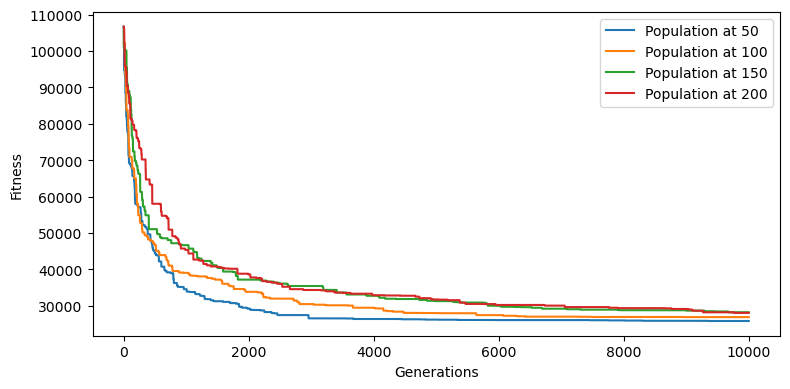

In [32]:
min_score_at_every_generation_for_different_population = {} 
last_population_score = {}
populations = [50, 100, 150, 200]

for population_size in populations:
    min_score_at_every_generation = []
    population = initPopulation(population_size)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('TWO_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('INVERSION', child_1)
        chid_2_after_mutation = performMutation('INVERSION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
    
    min_score_index = scores.index(min(scores))
    print(population[min_score_index])
    print(min(scores)) 
    min_score_at_every_generation_for_different_population[population_size] = min_score_at_every_generation
    
   

x_values = values_list = [i for i in range(termination_criteria + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (population_size, scores) in min_score_at_every_generation_for_different_population.items():
    ax_1.plot(x_values, scores, label= "Population at " + str(population_size))
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()

### Experiment 1 - Convergence curve for Burma14
#### Convergence curve for different populations are displayed below.

[10, 8, 9, 7, 0, 1, 13, 2, 3, 4, 5, 11, 6, 12]
3336.0
[5, 11, 6, 12, 7, 10, 8, 9, 0, 1, 13, 2, 3, 4]
3323.0
[1, 0, 9, 8, 10, 7, 12, 6, 11, 5, 4, 3, 2, 13]
3323.0
[1, 13, 2, 3, 4, 5, 11, 6, 12, 7, 10, 8, 9, 0]
3323.0


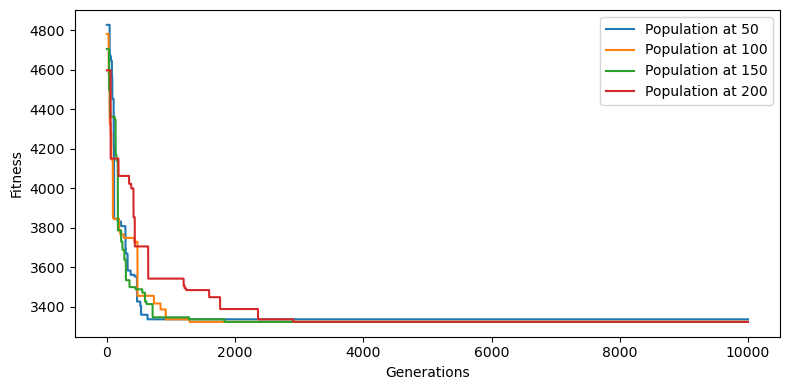

In [90]:
min_score_at_every_generation_for_different_population = {} 
populations = [50, 100, 150, 200]

for population_size in populations:
    min_score_at_every_generation = []
    population = initPopulation(population_size)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('ONE_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_1)
        chid_2_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
        
        
    min_score_index = scores.index(min(scores))
    print(population[min_score_index])
    print(min(scores)) 
    min_score_at_every_generation_for_different_population[population_size] = min_score_at_every_generation
    

x_values = values_list = [i for i in range(termination_criteria + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (population_size, scores) in min_score_at_every_generation_for_different_population.items():
    ax_1.plot(x_values, scores, label= "Population at " + str(population_size))
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()

### Experiment 2 - Diversity table for unique strings (Brazil58)
#### Determines the percentage of unique strings based on the population

In [75]:
populations = [50, 100, 150, 200, 250]
population_paths = {}

for population_size in populations:
    population = initPopulation(population_size)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('ONE_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_1)
        chid_2_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        generation += 1
    population_paths[population_size] = population
        

for (size, population) in population_paths.items():
    unique_paths = set(tuple(path) for path in population)
    count_of_unique = len(unique_paths)
    per = count_of_unique / len(population)
    print("% of unique for " + str(size) + " = " + str(per))

% of unique for 50 = 0.94
% of unique for 100 = 0.99
% of unique for 150 = 1.0
% of unique for 200 = 0.995


### Experiment 2 - Diversity table for unique strings (Burma14)
#### Determines the percentage of unique strings based on the population

In [91]:
populations = [50, 100, 150, 200]
population_paths = {}

for population_size in populations:
    population = initPopulation(population_size)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('ONE_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_1)
        chid_2_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        generation += 1
    population_paths[population_size] = population
        

for (size, population) in population_paths.items():
    unique_paths = set(tuple(path) for path in population)
    count_of_unique = len(unique_paths)
    per = count_of_unique / len(population)
    print("% of unique for " + str(size) + " = " + str(per))

% of unique for 50 = 0.16
% of unique for 100 = 0.15
% of unique for 150 = 0.08666666666666667
% of unique for 200 = 0.035


### Experiment 3 - Changing tournament size to see its impact on fitness (Brazil58)

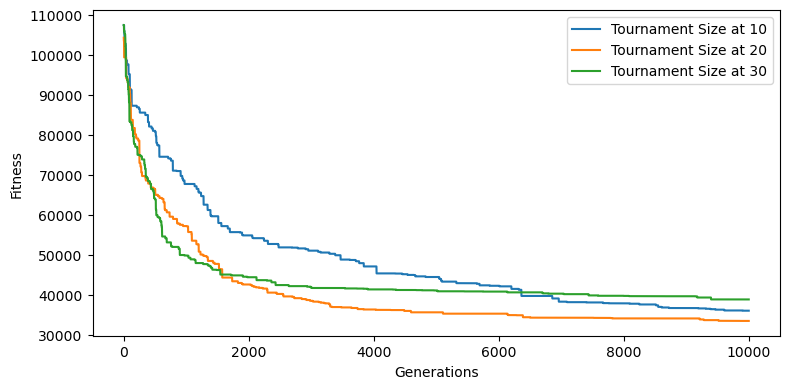

In [76]:
min_score_at_every_generation_for_different_population = {} 
tournaments = [10, 20, 30]

for tournament_size in tournaments:
    min_score_at_every_generation = []
    population = initPopulation(150)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('ONE_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_1)
        chid_2_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
    min_score_at_every_generation_for_different_population[tournament_size] = min_score_at_every_generation
    

x_values = values_list = [i for i in range(10000 + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (tournament_size, scores) in min_score_at_every_generation_for_different_population.items():
    ax_1.plot(x_values, scores, label= "Tournament Size at " + str(tournament_size))
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()

### Experiment 3 - Changing tournament size to see its impact on fitness (Burma14)

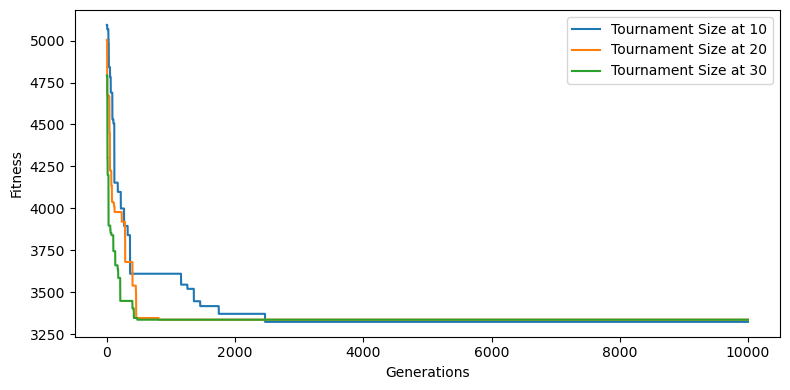

In [100]:
min_score_at_every_generation_for_different_population = {} 
tournaments = [10, 20, 30]

for tournament_size in tournaments:
    min_score_at_every_generation = []
    population = initPopulation(150)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('ONE_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_1)
        chid_2_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
    min_score_at_every_generation_for_different_population[tournament_size] = min_score_at_every_generation
    

x_values = values_list = [i for i in range(10000 + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (tournament_size, scores) in min_score_at_every_generation_for_different_population.items():
    ax_1.plot(x_values, scores, label= "Tournament Size at " + str(tournament_size))
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()

### Experiment 4 - Changing types of crossover to see its impact on fitness (Brazil58)

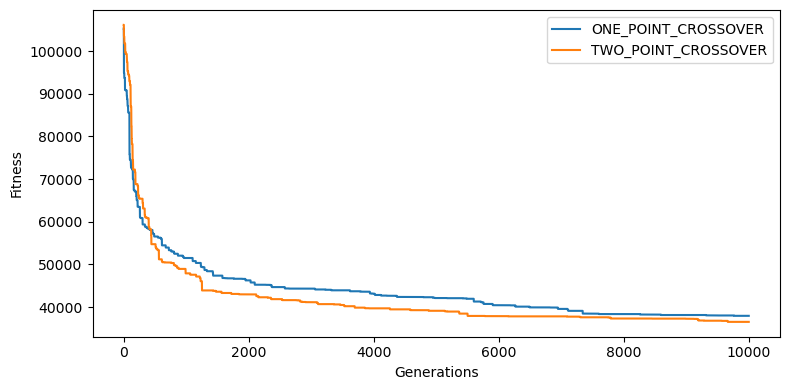

In [77]:
min_score_at_every_generation_for_different_crossover = {} # Holds the minimum value of the population at each generation for the convergence graph
crossovers = ['ONE_POINT_CROSSOVER', 'TWO_POINT_CROSSOVER']

for crossover in crossovers:
    min_score_at_every_generation = []
    population = initPopulation(100)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover(crossover, parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_1)
        chid_2_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
    min_score_at_every_generation_for_different_crossover[crossover] = min_score_at_every_generation
    

    

x_values = values_list = [i for i in range(termination_criteria + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (crossover, scores) in min_score_at_every_generation_for_different_crossover.items():
    ax_1.plot(x_values, scores, label= crossover)
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()

### Experiment 4 - Changing types of crossovers to see its impact on fitness (Burma14)

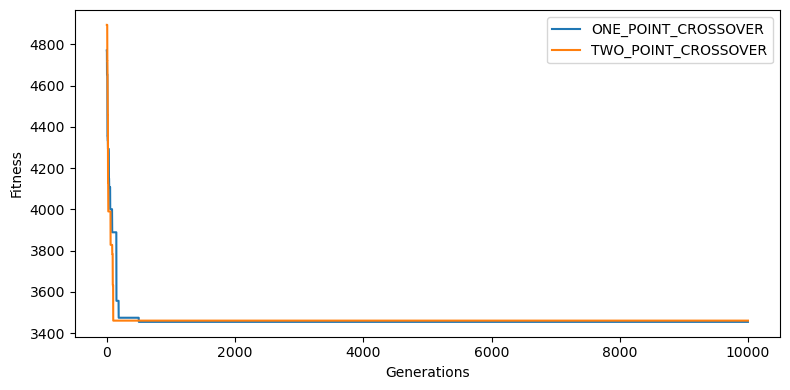

In [93]:
min_score_at_every_generation_for_different_crossover = {} # Holds the minimum value of the population at each generation for the convergence graph
crossovers = ['ONE_POINT_CROSSOVER', 'TWO_POINT_CROSSOVER']

for crossover in crossovers:
    min_score_at_every_generation = []
    population = initPopulation(100)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover(crossover, parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_1)
        chid_2_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
    min_score_at_every_generation_for_different_crossover[crossover] = min_score_at_every_generation
    

    

x_values = values_list = [i for i in range(termination_criteria + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (crossover, scores) in min_score_at_every_generation_for_different_crossover.items():
    ax_1.plot(x_values, scores, label= crossover)
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()

### Experiment 5 - Changing types of mutations to see its impact on fitness (Brazi58)

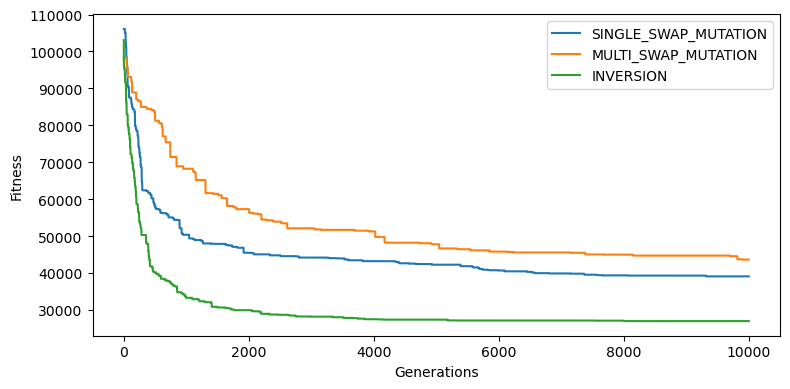

In [78]:
min_score_at_every_generation_for_different_mutation = {} # Holds the minimum value of the population at each generation for the convergence graph
mutations = ['SINGLE_SWAP_MUTATION', 'MULTI_SWAP_MUTATION', 'INVERSION']

for mutation in mutations:
    min_score_at_every_generation = []
    population = initPopulation(100)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('ONE_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation(mutation, child_1)
        chid_2_after_mutation = performMutation(mutation, child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
    min_score_at_every_generation_for_different_mutation[mutation] = min_score_at_every_generation

x_values = values_list = [i for i in range(termination_criteria + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (mutation, scores) in min_score_at_every_generation_for_different_mutation.items():
    ax_1.plot(x_values, scores, label= mutation)
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()

### Experiment 5 - Changing types of mutations to see its impact on fitness (Burma14)

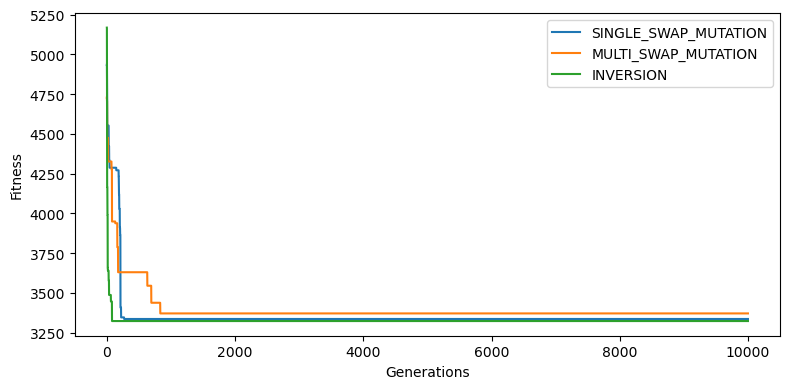

In [94]:
min_score_at_every_generation_for_different_mutation = {} # Holds the minimum value of the population at each generation for the convergence graph
mutations = ['SINGLE_SWAP_MUTATION', 'MULTI_SWAP_MUTATION', 'INVERSION']

for mutation in mutations:
    min_score_at_every_generation = []
    population = initPopulation(100)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('ONE_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation(mutation, child_1)
        chid_2_after_mutation = performMutation(mutation, child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, 'REPLACE_WORST')

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
    min_score_at_every_generation_for_different_mutation[mutation] = min_score_at_every_generation

x_values = values_list = [i for i in range(termination_criteria + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (mutation, scores) in min_score_at_every_generation_for_different_mutation.items():
    ax_1.plot(x_values, scores, label= mutation)
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()

### Experiment 6 - Changing types of replacement to see its impact on fitness (Brazil58)

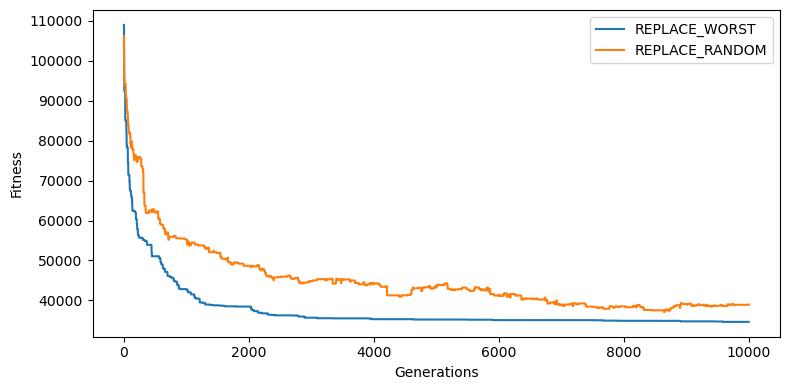

In [79]:
min_score_at_every_generation_for_different_replacement = {} # Holds the minimum value of the population at each generation for the convergence graph
replacements = ['REPLACE_WORST', 'REPLACE_RANDOM']

for replacement in replacements:
    min_score_at_every_generation = []
    population = initPopulation(100)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('ONE_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_1)
        chid_2_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, replacement)

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
    min_score_at_every_generation_for_different_replacement[replacement] = min_score_at_every_generation

x_values = values_list = [i for i in range(termination_criteria + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (replacement, scores) in min_score_at_every_generation_for_different_replacement.items():
    ax_1.plot(x_values, scores, label= replacement)
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()

### Experiment 6 - Changing types of replacement to see its impact on fitness (Burma14)

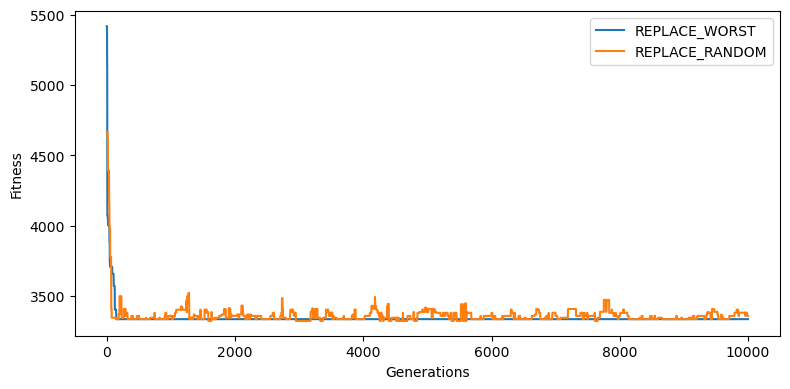

In [96]:
min_score_at_every_generation_for_different_replacement = {} # Holds the minimum value of the population at each generation for the convergence graph
replacements = ['REPLACE_WORST', 'REPLACE_RANDOM']

for replacement in replacements:
    min_score_at_every_generation = []
    population = initPopulation(100)
    generation = 0
    while generation <= termination_criteria:
        scores = []
        parent_1 = tournamentSelection(population, tournament_size)
        parent_2 = tournamentSelection(population, tournament_size)
        parent_1_path = parent_1[0]
        parent_2_path = parent_2[0]
        child_1, child_2 = performCrossover('ONE_POINT_CROSSOVER', parent_1_path, parent_2_path)
        chid_1_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_1)
        chid_2_after_mutation = performMutation('SINGLE_SWAP_MUTATION', child_2)
        population = performReplacement(population, chid_1_after_mutation, chid_2_after_mutation, replacement)

        for i in population:
            score = calculateTotalFitness(i, matrix)
            scores.append(score)

        min_score_at_every_generation.append(min(scores))
        generation += 1
    min_score_at_every_generation_for_different_replacement[replacement] = min_score_at_every_generation

x_values = values_list = [i for i in range(termination_criteria + 1)]  
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for (replacement, scores) in min_score_at_every_generation_for_different_replacement.items():
    ax_1.plot(x_values, scores, label= replacement)
        
ax_1.legend(loc=0)
ax_1.set_xlabel('Generations')
ax_1.set_ylabel('Fitness')
fig_1.tight_layout()